In [ ]:
# %pip install geopandas
# %pip install rasterio
# %pip install scipy
# %pip install pydantic

# Develop and Test GIS Functions

This notebook is for developing and testing the GIS functions implemented in `functions.py` using open-source libraries such as geopandas, rasterio, numpy, and scipy.

In [ ]:
# Import Required Libraries
import os
import sys
import unittest
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
import scipy
import rasterio
from rasterio.mask import mask
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt


In [ ]:
# Import functions from functions.py
cur_dir = os.path.abspath('.')
if cur_dir not in sys.path:
    sys.path.append(cur_dir)  # Ensure current directory is in path
backend_dir = os.path.abspath('../backend')
if backend_dir not in sys.path:
    sys.path.append(backend_dir)  # Ensure backend directory is in path
# print(sys.path)

root_dir = os.path.abspath(f"..")
# root_dir

In [16]:
import importlib
import app.gis.functions as fs
import app.gis.tools as tools
import app.gis.engine as engine
importlib.reload(fs)
importlib.reload(engine)
importlib.reload(tools)
print(tools.version)

2025-08-22 16:09:33


In [ ]:
# extract a specific district (e.g., '002') from the territorial authority shapefile
input_shp=f'{root_dir}/test-data/statsnz-territorial-authority-2025-clipped-SHP/territorial-authority-2025-clipped.shp'
output_shp=f'{root_dir}/output-data/district.shp'
fs.RPL_Select_analysis(
    input_shp=input_shp,
    output_shp=output_shp,
    conditions_expression=f"TA2025_V1_ == '001'"
)
tools.show_shapefile_plot(output_shp)

In [ ]:
# clip the lake polygons to the district boundary
all_lake_shp = f'{root_dir}/test-data/lds-nz-lake-polygons-topo-150k-SHP/nz-lake-polygons-topo-150k.shp'
district_shp=f'{root_dir}/output-data/district.shp'
lake_in_district_shp=f'{root_dir}/output-data/lake-in-district.shp'
fs.RPL_Clip_analysis(
    output=lake_in_district_shp,
    whole_area=all_lake_shp,
    boundary=district_shp
)
tools.show_shapefile_plot(lake_in_district_shp)

In [ ]:
# Create buffer for lake areas in a specific district
lake_in_district_shp=f'{root_dir}/output-data/lake-in-district.shp'
buffered_lake_in_district_shp=f'{root_dir}/output-data/buffered-lake-in-district.shp'
fs.RPL_Buffer_analysis(
    input=lake_in_district_shp,
    output=buffered_lake_in_district_shp,
    buffer_distance=500
)
tools.show_shapefile_plot(buffered_lake_in_district_shp)

In [ ]:
# clip the residential polygons to the district boundary
all_residential_shp = f'{root_dir}/test-data/lds-nz-residential-area-polygons-topo-150k-SHP/nz-residential-area-polygons-topo-150k.shp'
district_shp=f'{root_dir}/output-data/district.shp'
residential_in_district_shp=f'{root_dir}/output-data/residential-in-district.shp'
fs.RPL_Clip_analysis(
    output=residential_in_district_shp,
    whole_area=all_residential_shp,
    boundary=district_shp
)
tools.show_shapefile_plot(residential_in_district_shp)

In [ ]:
# Create buffer for residential areas in a specific district
residential_in_district_shp=f'{root_dir}/output-data/residential-in-district.shp'
buffered_residential_in_district_shp=f'{root_dir}/output-data/buffered-residential-in-district.shp'
fs.RPL_Buffer_analysis(
    input=residential_in_district_shp,
    output=buffered_residential_in_district_shp,
    buffer_distance=1000
)
tools.show_shapefile_plot(buffered_residential_in_district_shp)

In [ ]:
# union buffered lake and residential areas in a specific district
buffered_lake_in_district_shp=f'{root_dir}/output-data/buffered-lake-in-district.shp'
buffered_residential_in_district_shp=f'{root_dir}/output-data/buffered-residential-in-district.shp'
unioned_in_district_shp=f'{root_dir}/output-data/unioned-in-district.shp'


fs.RPL_Union_analysis([buffered_lake_in_district_shp, buffered_residential_in_district_shp], unioned_in_district_shp)
tools.show_shapefile_plot(unioned_in_district_shp)

In [17]:
# extract rasters for the district area
annual_solar_radiation_raster = f'{root_dir}/test-data/lris-lenz-mean-annual-solar-radiation-GTiff/solar_2193.tif'
slope_raster = f'{root_dir}/test-data/lris-lenz-slope-GTiff/slope_2193.tif'
temperature_raster = f'{root_dir}/test-data/lris-lenz-mean-annual-temperature-GTiff/temperature_2193.tif'
district_shp=f'{root_dir}/output-data/district.shp'
solar_in_district_raster = f'{root_dir}/output-data/solar-in-district.tif'
slope_in_district_raster = f'{root_dir}/output-data/slope-in-district.tif'
temperature_in_district_raster = f'{root_dir}/output-data/temperature-in-district.tif'


fs.RPL_ExtractByMask(annual_solar_radiation_raster, district_shp, solar_in_district_raster)
fs.RPL_ExtractByMask(slope_raster, district_shp, slope_in_district_raster)
fs.RPL_ExtractByMask(temperature_raster, district_shp, temperature_in_district_raster)

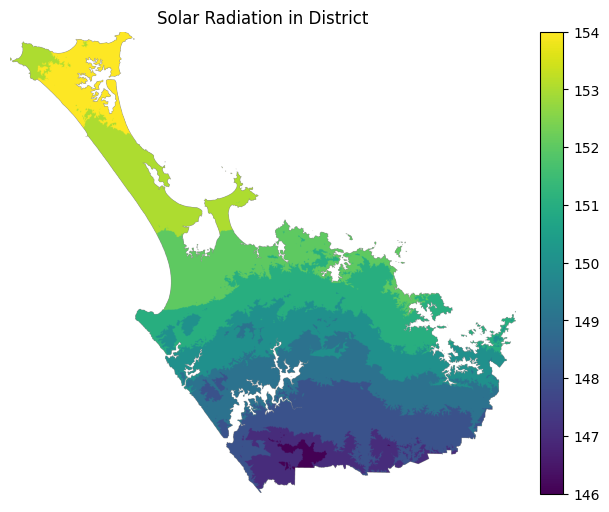

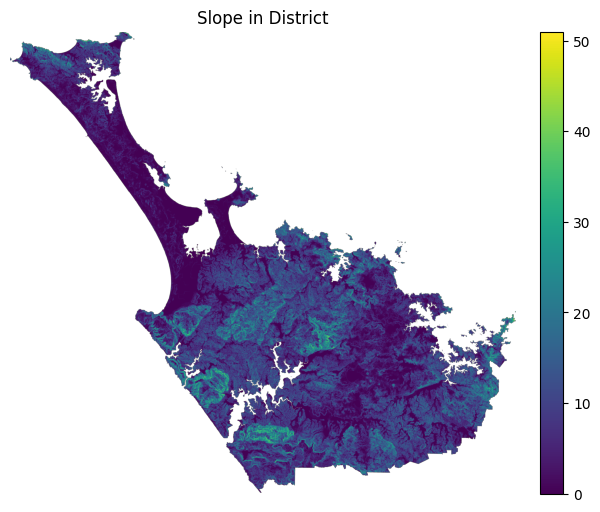

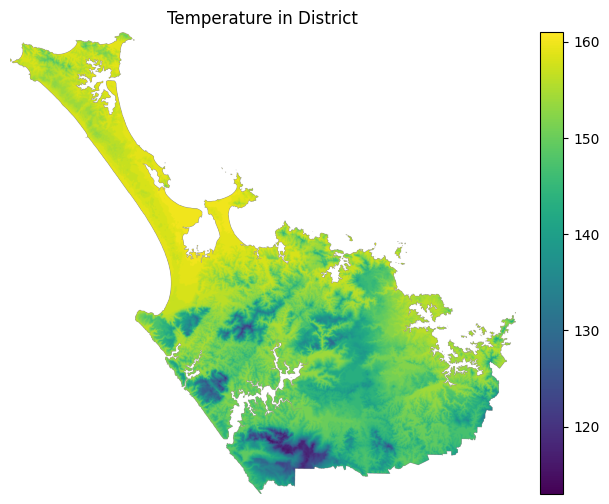

In [18]:
tools.show_raster_plot(solar_in_district_raster, title='Solar Radiation in District')
tools.show_raster_plot(slope_in_district_raster, title='Slope in District')
tools.show_raster_plot(temperature_in_district_raster, title='Temperature in District')

In [ ]:
# Reclassify the slope raster into score categories
slope_in_district=f'{root_dir}/output-data/slope-in-district.tif'
scored_slope_in_district=f'{root_dir}/output-data/scored-slope-in-district.tif'
fs.RPL_Reclassify(input_raster=slope_in_district, output_raster=scored_slope_in_district, remap_range=[
    (0, 5, 10),
    (5, 10, 8),
    (10, 15, 5),
    (15, 90, 2)
])
tools.show_raster_plot(scored_slope_in_district, title='Scored Slope in District')

In [ ]:
# convert the unioned shapefile to raster
unioned_in_district_shp=f'{root_dir}/output-data/unioned-in-district.shp'
unioned_in_district_raster=f'{root_dir}/output-data/unioned-in-district_raster.tif'
fs.RPL_PolygonToRaster_conversion(unioned_in_district_shp, unioned_in_district_raster, slope_in_district_raster)

In [ ]:
print(tools.get_data_range(unioned_in_district_raster))
tools.show_raster_plot(unioned_in_district_raster, title='Unioned in District Raster')

In [ ]:
# clip powerline shapefile to the district boundary
powerline_shapefile = f'{root_dir}/test-data/lds-nz-powerline-centrelines-topo-150k-SHP/nz-powerline-centrelines-topo-150k.shp'
powerline_in_district_shp = f'{root_dir}/output-data/powerline-in-district.shp'
fs.RPL_Clip_analysis(
    output=powerline_in_district_shp,
    whole_area=powerline_shapefile,
    boundary=district_shp
)
tools.show_shapefile_plot(powerline_in_district_shp)

In [ ]:
# Rasterize the powerline-in-district shapefile
powerline_in_district_raster = f'{root_dir}/output-data/powerline-in-district_raster.tif'
fs.RPL_PolygonToRaster_conversion(powerline_in_district_shp, powerline_in_district_raster, slope_in_district_raster)
print(tools.get_data_range(powerline_in_district_raster))
tools.show_raster_plot(powerline_in_district_raster, title='Powerline in District Raster')

In [ ]:
# Calculate distance to powerline in district
distance_powerline_in_district_raster = f'{root_dir}/output-data/distance-powerline-in-district_raster.tif'
fs.RPL_DistanceAccumulation(powerline_in_district_raster, distance_powerline_in_district_raster)
print(tools.get_data_range(distance_powerline_in_district_raster))
tools.show_raster_plot(distance_powerline_in_district_raster, title='Distance to Powerline in District Raster')

In [ ]:
# Reclassify the powerline raster into score categories
scored_powerline_in_district=f'{root_dir}/output-data/scored-powerline-in-district.tif'
fs.RPL_Reclassify(input_raster=distance_powerline_in_district_raster, output_raster=scored_powerline_in_district, remap_range=[
   [0, 1000, 10],
[1000, 2000, 8],
[2000, 3000, 5],
[3000, float('inf'), 2]
])
print(tools.get_data_range(scored_powerline_in_district))
tools.show_raster_plot(scored_powerline_in_district, title='Scored Powerline in District')

### distance calculation test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

# Create a simple 5x5 raster to simulate roads
# 1 represents road, 0 represents other areas
road_raster = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=np.uint8)

# Invert road positions (road is False, others are True)
inverse_mask = (road_raster == 0)

# Calculate Euclidean distance (in pixels)
distance = distance_transform_edt(inverse_mask)

# Show original road positions and distance map
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Show road positions
axs[0].imshow(road_raster, cmap='gray_r')
axs[0].set_title('Road Raster (1=road)')
axs[0].axis('off')

# Show distance map
im = axs[1].imshow(distance, cmap='viridis')
axs[1].set_title('Euclidean Distance Transform')
axs[1].axis('off')

# Show colorbar
fig.colorbar(im, ax=axs[1])

plt.show()

# Print numeric results
print("Distance Transform Result (in pixels):\n", distance)

### Extract all territorial authorities from shapefile

In [ ]:

input_shp=f'{root_dir}/test-data/statsnz-territorial-authority-2025-clipped-SHP/territorial-authority-2025-clipped.shp'
# show attribute table of a shapfile

gdf = gpd.read_file(input_shp)
# gdf.head(10)
# only show two columns, and sort the TA2025_V_2 field using alphabetical order, and convert every item to a tuple, and convert to list[tuple]
gdf[['TA2025_V1_', 'TA2025_V_2']].sort_values('TA2025_V_2').apply(tuple, axis=1).tolist()
# gdf[['TA2025_V1_', 'TA2025_V_2']].rename(columns={'TA2025_V1_': 'name', 'TA2025_V_2': 'code'}).to_dict(orient='records')